# RUN THIS CELL FOR IMPORTING NECESSARY PACKAGES - MUST

In [1]:
# =========================
# 📦 IMPORTS (Clean Version)
# =========================

# ---- Standard Library ----
import os, re, gc, math, json, zipfile
from pathlib import Path


# ---- Third-Party Core ----
import numpy as np
import cv2
import tifffile as tiff
from tqdm.std import tqdm   # plain tqdm (no ipywidgets)

# ---- PyTorch & Detectron2 ----
import torch
import torch.nn as nn
import torch.nn.functional as F
from detectron2 import model_zoo
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.modeling import META_ARCH_REGISTRY
from detectron2.modeling.backbone.fpn import build_resnet_fpn_backbone
from detectron2.layers import ShapeSpec
from detectron2.config import get_cfg

# ---- Visualization ----
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage.measure import marching_cubes

# ---- Environment / Notebook ----
os.environ["TQDM_NOTEBOOK"] = "0"   # ensure tqdm uses text bars
os.environ.pop("DISPLAY", None)   
%matplotlib inline
# /global/cfs/cdirs/als/synaps/rec20211222_125057_petiole4

/global/homes/e/elavarpa/.conda/envs/beam8x_semseg/lib/python3.10/site-packages/detectron2/model_zoo/model_zoo.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


## RUN THIS CELL IF YOU HAVE A ZIPPED FOLDER TO BE EXTRACTED, SKIP OTHERWISE

In [17]:
import zipfile
import os

# replace 'your_file.zip' with your actual file name
file_name = 'INPUT ZIP FILE'
#Replace OUTPUT_FOLDER with the desired output location to which the files will be extracted to
extract_path = 'OUTPUT_FOLDER'  # output folder

os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(file_name, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Files extracted to:", extract_path)

Files extracted to: /pscratch/sd/e/elavarpa/reconstructions_new


In [19]:

#this should be the name of the folder that has reconstructions or the parent folder of the folder with the extracted files 

inputSubFolderName = "/pscratch/sd/e/elavarpa/reconstructions_new"  



#outputSubfolderName = "/pscratch/sd/e/elavarpa/moth-masks" #this can be anything you want, I usually choose the current date

inputPath = os.path.join("/alsdata", inputSubFolderName)

###########################

WEIGHTS_PATH = "/pscratch/sd/e/elavarpa/model_final.pth"   # The path to where the model weights are stored

#inputPath = os.path.join(".", inputSubFolderName)

if os.path.isdir("/alsuser/pscratch"):
    wheretosave = "pscratch"
elif os.path.isdir("/alsuser/cscratch"):  
    wheretosave = "cscratch"
else:
    wheretosave = "notebooks"    

filenamelist = os.listdir(inputPath)
filenamelist.sort()
for i in range(len(filenamelist)-1,np.maximum(len(filenamelist)-10000,-1),-1):
    print(f'{i}: {filenamelist[i]}')

32: reconstructions_new_1.pkl
31: reconstructions_new.pkl
30: rec20251113_165502_M49_Clot2
29: rec20241223_165650_Mina_olive_TE1_10x_2
28: rec20241222_223102_mothhead2_2_10x
27: rec20240425_154624_nist-sand-100-325_27keV_z8mm_n1969
26: rec20240425_150710_nist-sand-70-200_27keV_z8mm_n657
25: rec20240419_220630_Arun_NCSU_AA6061_NCSE_Cu_FSE
24: rec20240419_215532_Arun_NCSU_AA6061_MHEA_FSE
23: rec20240419_214330_Arun_NCSU_AA6061_RHEA_ORNL_FSE
22: rec20240419_213200_Arun_NCSU_Al21_SmC05_SSE_Periphery
21: rec20240419_211948_Arun_NCSU_Al_3point76_SmCo5_half_disc
20: rec20240419_210529_Arun_NCSU_SS316L_FSE
19: rec20240419_205458_Arun_NCSU_AA6061_IR_Swarth_FSE
18: rec20240419_204238_Arun_NCSU_Brass_chips_FSE
17: rec20240419_202643_Arun_NCSU_AA6061_Fe3O4_FSE_scan_2
16: rec20240419_201208_Arun_Serpentinite_Sample_2_Scan_4
15: rec20240419_200220_Arun_Serpentinite_Sample_2_Scan_3
14: rec20240419_195401_Arun_Serpentinite_Sample_2_Scan_1
13: rec20240419_194629_Arun_Serpentinite_Sample_2_Scan_1
12: re

In [3]:
folder_name = filenamelist[1] #update this number with the index of the file you want to process from the directory listing generated in the previous cell
folder_path = os.path.join(inputPath, folder_name)
print(folder_path)
print(folder_name + 'oo')
# outputSubfolderName = f"{folder_name}_masks"#this can be anything you want, I usually choose the current date    
# outputPath = os.path.join("/alsuser/", wheretosave, outputSubfolderName)    

# if not os.path.exists(outputPath):
#     os.mkdir(outputPath)

/global/cfs/cdirs/als/synaps/rec20211222_125057_petiole4/20211222_125057_petiole4_00001.tiff
20211222_125057_petiole4_00001.tiffoo


# THE CELL BELOW HAS UTILITY FUNCTIONS - MUST RUN

In [5]:
SEED = 50
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# -----------------
# Classes (id layout matches your training)
# 0=Background, 1..K=foreground classes
# -----------------
CLASSES = ["Background", "Bright", "Dark Gray", "Light Gray", "Porosity", "Sample"]
NUM_CLASSES = len(CLASSES)

# These are the 4 classes you want volumes for (if needed later)
VOLUME_CLASSES = ["Bright", "Light Gray", "Dark Gray", "Porosity"]
VOLUME_CLASS_IDS = [CLASSES.index(c) for c in VOLUME_CLASSES]

# -----------------
# Utilities
# -----------------
def numeric_key(p: Path):
    m = re.findall(r"(\d+)", p.stem)
    return int(m[-1]) if m else p.stem

def list_tiffs(root: Path):
    return sorted([p for p in root.rglob("*") if p.suffix.lower() in (".tif", ".tiff")], key=numeric_key)

def resize_hw(h, w, resize_to):
    """None: keep; int: scale longest side; (H,W): force."""
    if resize_to is None: return h, w
    if isinstance(resize_to, int):
        s = resize_to / float(max(h, w))
        return max(1, int(round(h*s))), max(1, int(round(w*s)))
    if isinstance(resize_to, (tuple, list)) and len(resize_to) == 2:
        return int(resize_to[0]), int(resize_to[1])
    raise ValueError("RESIZE_TO must be None, int, or (H,W)")

def _robust_u8_scale(a: np.ndarray, lo: float, hi: float) -> np.uint8:
    """Clip+scale to [0,255] using fixed lo/hi (float32-safe, NaN-safe)."""
    a = np.asarray(a, dtype=np.float32)
    a = np.where(np.isfinite(a), a, lo)
    if hi <= lo: hi = lo + 1e-6
    a = np.clip((a - lo) * (255.0 / (hi - lo)), 0, 255)
    return (a + 0.5).astype(np.uint8)

def to_bgr_u8_with_scale(img: np.ndarray, lo: float, hi: float, assume_rgb=True) -> np.ndarray:
    """
    Convert HxW or HxWxC image to HxWx3 uint8 BGR using a FIXED per-stack (lo, hi).
    Set assume_rgb=True if TIFFs are RGB; it will flip to BGR for Detectron2.
    """
    a = np.asarray(img)
    if a.ndim == 2:
        g8 = _robust_u8_scale(a, lo, hi)
        return cv2.cvtColor(g8, cv2.COLOR_GRAY2BGR)
    if a.ndim == 3:
        a3 = a[..., :3]
        ch = [_robust_u8_scale(a3[..., c], lo, hi) for c in range(3)]
        rgb8 = np.stack(ch, axis=-1)
        return cv2.cvtColor(rgb8, cv2.COLOR_RGB2BGR) if assume_rgb else rgb8
    raise ValueError(f"Unsupported image shape: {a.shape}")

# ---- Subset-based percentile estimation (≈30% spread across stack) ----
def pick_spread_subset(files, frac=0.30, seed=42):
    """Pick ~frac of files, spread across the stack with light randomness."""
    n = len(files)
    k = max(1, int(math.ceil(frac * n)))
    lin = np.linspace(0, n - 1, k, dtype=int)
    rng = np.random.default_rng(seed)
    win = max(1, n // (8 * k))  # small jitter window to avoid periodic picks
    jit = rng.integers(-win, win + 1, size=k) if win > 0 else 0
    idx = np.clip(lin + jit, 0, n - 1)
    return sorted(set(int(i) for i in idx))

def sample_percentiles_from_files(files, p_lo=1.0, p_hi=99.0, max_total_samples=5_000_000):
    """Estimate lo/hi percentiles from a given list of files via pixel subsampling."""
    remain = max_total_samples
    samples = []
    for i, f in enumerate(tqdm(files), 1):
        a = tiff.imread(str(f))
        if a.ndim == 3: a = a[..., 0]  # one channel is enough for stats
        a = a[np.isfinite(a)]
        if a.size == 0: 
            continue
        left = len(files) - i + 1
        take = max(1, remain // max(1, left))
        if take >= a.size:
            samples.append(a.ravel())
            remain -= a.size
        else:
            idx = np.random.choice(a.size, take, replace=False)
            samples.append(a.ravel()[idx])
            remain -= take
        if remain <= 0:
            break

    if not samples:
        return 0.0, 1.0
    S = np.concatenate(samples).astype(np.float32, copy=False)
    lo, hi = np.percentile(S, [p_lo, p_hi])
    if not np.isfinite(lo): lo = float(np.nanmin(S))
    if not np.isfinite(hi): hi = float(np.nanmax(S))
    if hi <= lo: hi = lo + 1e-6
    return float(lo), float(hi)


# THE CELL BELOW LOADS MODEL CONFIGS - MUST RUN

In [6]:
# =====  model, cfg, weights =====
# Simple multi-label FPN head
ARCH_NAME = "MultiLabelSemSeg_v3"
if ARCH_NAME in META_ARCH_REGISTRY._obj_map:
    del META_ARCH_REGISTRY._obj_map[ARCH_NAME]

class_weights = torch.ones(NUM_CLASSES, dtype=torch.float32)

@META_ARCH_REGISTRY.register()
class MultiLabelSemSeg_v3(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.device = torch.device(cfg.MODEL.DEVICE)
        self.num_classes = cfg.MODEL.SEM_SEG_HEAD.NUM_CLASSES
        self.out_channels = cfg.MODEL.FPN.OUT_CHANNELS
        self.pixel_mean = torch.tensor(cfg.MODEL.PIXEL_MEAN).view(3, 1, 1).to(self.device)
        self.pixel_std  = torch.tensor(cfg.MODEL.PIXEL_STD).view(3, 1, 1).to(self.device)
        self.class_weights = class_weights.to(self.device)

        self.backbone = build_resnet_fpn_backbone(cfg, ShapeSpec(channels=3))
        self.head = nn.Conv2d(self.out_channels, self.num_classes, kernel_size=1)
        self.size_divisibility = 32
        self.to(self.device)

    def normalize(self, x):
        x = x.float()  # 0..255 float expected
        return (x - self.pixel_mean) / self.pixel_std

    @torch.no_grad()
    def forward(self, batched_inputs):
        from detectron2.structures import ImageList
        imgs = [x["image"].to(self.device) for x in batched_inputs]
        orig_sizes = [im.shape[-2:] for im in imgs]
        imgs = [self.normalize(im) for im in imgs]
        images = ImageList.from_tensors(imgs, size_divisibility=self.size_divisibility)

        feats = self.backbone(images.tensor)
        x = feats["p2"]
        logits = self.head(x)
        logits = F.interpolate(logits, size=images.tensor.shape[-2:], mode="bilinear", align_corners=False)

        out = []
        probs = torch.sigmoid(logits)
        for b, (H, W) in enumerate(orig_sizes):
            out.append({"sem_seg_probs": probs[b, :, :H, :W].detach().cpu()})
        return out

# ---- Build cfg and load weights ----
cfg = get_cfg()
cfg.MODEL.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
cfg.merge_from_file(model_zoo.get_config_file("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml"))
cfg.MODEL.META_ARCHITECTURE = ARCH_NAME
cfg.MODEL.SEM_SEG_HEAD.NUM_CLASSES = NUM_CLASSES
cfg.MODEL.FPN.OUT_CHANNELS = 256
cfg.INPUT.FORMAT = "BGR"

print("INPUT.FORMAT =", cfg.INPUT.FORMAT)
print("PIXEL_MEAN   =", cfg.MODEL.PIXEL_MEAN)
print("PIXEL_STD    =",  cfg.MODEL.PIXEL_STD)

model = MultiLabelSemSeg_v3(cfg).eval()

# Point to your trained weights
# WEIGHTS_PATH = "/pscratch/sd/e/elavarpa/model_final.pth"
DetectionCheckpointer(model).load(WEIGHTS_PATH)
print("Loaded:", WEIGHTS_PATH)

DEVICE = torch.device(cfg.MODEL.DEVICE)
print("Device:", DEVICE)


INPUT.FORMAT = BGR
PIXEL_MEAN   = [103.53, 116.28, 123.675]
PIXEL_STD    = [1.0, 1.0, 1.0]
Loaded: /pscratch/sd/e/elavarpa/model_final.pth
Device: cuda


# THE CELL BELOW ESTIMATED THE PARAMETERS FOR FLOAT32 TO UINT8 CONVERSION - MUST RUN 

In [7]:
# ===== Stack setup & subset-based scaling (RUN FIRST) =====
# Choose the scan/folder you want to preview
INPUT_DIR      = Path(folder_path)
ASSUME_RGB_SRC = True   # False if the TIFFs are already BGR
RESIZE_TO      = None   # None | int | (H,W) 
FRACTION       = 0.5   ## Fraction of total stack used for computing parameters to covert to uint8

# Build the file list
all_imgs = list_tiffs(INPUT_DIR)
print(f"Found {len(all_imgs)} TIFFs under {INPUT_DIR}")
assert all_imgs, f"No TIFFs found in {INPUT_DIR}"

# Pick ~30% of files, spread across the stack, then estimate lo/hi from those files
subset_idx   = pick_spread_subset(all_imgs, frac=FRACTION, seed=60)
subset_files = [all_imgs[i] for i in subset_idx]
print(f"Using {len(subset_files)} files ({FRACTION * 100}%) for percentile estimation.")

print("Estimating global lo/hi from subset ...")
STACK_LO, STACK_HI = sample_percentiles_from_files(subset_files, p_lo=1.0, p_hi=99.0, max_total_samples=5_000_000)
print(f"Stack scale (subset): lo={STACK_LO:.6g}, hi={STACK_HI:.6g}")


Found 2160 TIFFs under /global/cfs/cdirs/als/synaps/rec20211222_125057_petiole4
Using 965 files (50.0%) for percentile estimation.
Estimating global lo/hi from subset ...


100%|█████████▉| 964/965 [03:30<00:00,  4.58it/s]

Stack scale (subset): lo=-20.9463, hi=22.0715


# PREVIEW SEGMENTATION RESULTS PER SLICE 
## CAN MODIFY THRESHOLD AND WHAT CLASSES TO DISPLAY

## CLASS INDEX REFERENCE

## 0 : BACKGROUND
## 1 : BRIGHT
## 2 : DARK GRAY
## 3 : LIGHT GRAY
## 4 : POROSITY
## 5 : SAMPLE


### MODIFY THRESHOLD VALUE TO MODIFY SEGMENTATAION RESULTS
### LOWER THRESOLD FOR LOWER CONFIDENCE AND VICE VERSA


Chosen indices: [845, 1527]
[845/2159] 20211222_125057_petiole4_00845.tiff


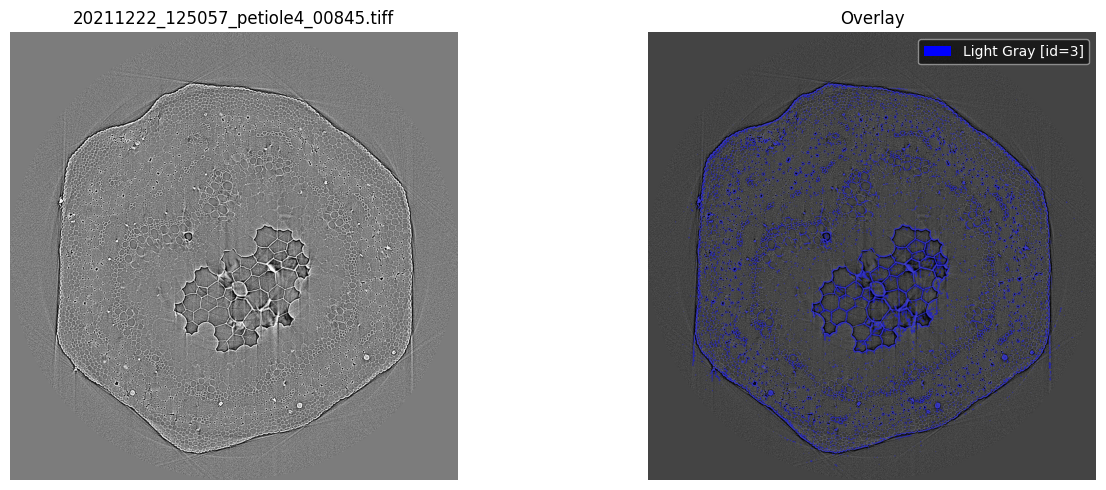

[1527/2159] 20211222_125057_petiole4_01527.tiff


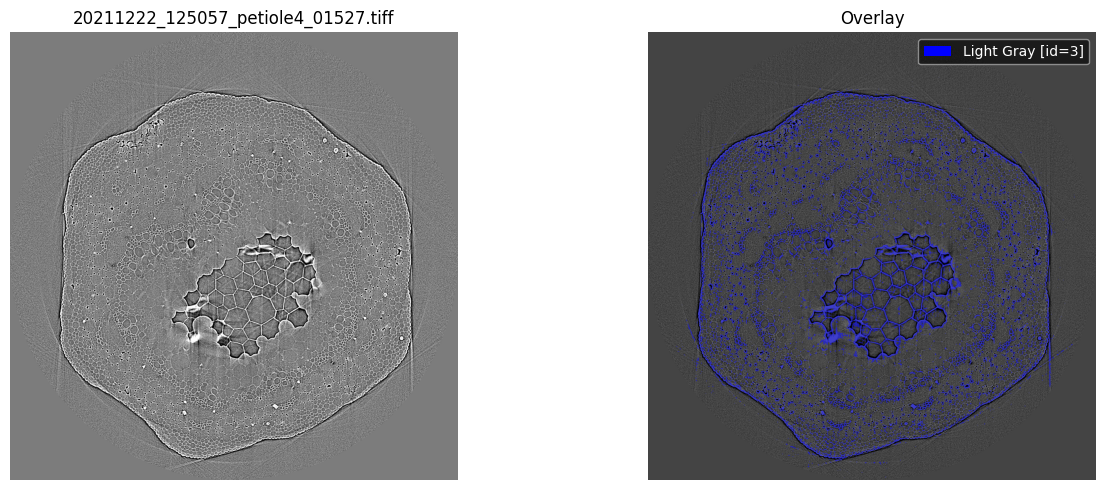

In [17]:
THRESHOLD      = 0.5
CLASSES_TO_SHOW= [3]     # change as needed upto 3 e.g. [1,2,3] or [2,3,4] or [1,3,5] 
BASE_DIM       = 0.55
OVERLAY_ALPHA  = 0.55
OVERLAY_COLORS = [(255,0,0),(0,255,0),(0,0,255)]  # BGR

@torch.no_grad()
def forward_probs_bgr_scaled(path: Path):
    im  = tiff.imread(str(path))
    bgr = to_bgr_u8_with_scale(im, STACK_LO, STACK_HI, assume_rgb=ASSUME_RGB_SRC)  # uint8 BGR
    chw = torch.as_tensor(bgr.transpose(2,0,1), dtype=torch.float32)               # 0..255 float32
    sample = {"image": chw.to(DEVICE)}
    with torch.cuda.amp.autocast(enabled=False):  # disable while debugging
        out = model([sample])
    probs = out[0]["sem_seg_probs"].numpy()  # [C,H,W] float32 CPU
    return bgr, probs

def preview_slice(i: int):
    assert 0 <= i < len(all_imgs), f"i must be in [0, {len(all_imgs)-1}]"
    p = all_imgs[i]
    print(f"[{i}/{len(all_imgs)-1}] {p.name}")

    bgr, probs = forward_probs_bgr_scaled(p)
    H, W = bgr.shape[:2]
    Ht, Wt = resize_hw(H, W, RESIZE_TO)

    if (Ht, Wt) != (H, W):
        probs = np.stack(
            [cv2.resize(probs[c], (Wt, Ht), interpolation=cv2.INTER_LINEAR)
             for c in range(NUM_CLASSES)],
            axis=0
        )
        base_gray = cv2.resize(bgr[..., 1], (Wt, Ht), interpolation=cv2.INTER_AREA)  # use green channel
        base_bgr  = cv2.cvtColor(base_gray, cv2.COLOR_GRAY2BGR)
    else:
        base_bgr = bgr

    base_dim = (base_bgr.astype(np.float32) * BASE_DIM).astype(np.uint8)
    preds    = (probs > THRESHOLD).astype(np.uint8)

    overlay = base_dim.copy()
    for k, cid in enumerate(CLASSES_TO_SHOW[:3]):
        m = preds[cid].astype(bool)
        if m.any():
            col = np.array(OVERLAY_COLORS[k], dtype=np.float32)  # BGR
            overlay[m] = ((1 - OVERLAY_ALPHA) * overlay[m].astype(np.float32) + OVERLAY_ALPHA * col).astype(np.uint8)

    fig = plt.figure(figsize=(14, 5))
    ax1 = fig.add_subplot(1, 2, 1); ax2 = fig.add_subplot(1, 2, 2)

    ax1.imshow(cv2.cvtColor(base_bgr, cv2.COLOR_BGR2RGB)); ax1.set_title(p.name); ax1.axis('off')
    ax2.imshow(cv2.cvtColor(overlay,  cv2.COLOR_BGR2RGB)); ax2.set_title("Overlay"); ax2.axis('off')

    handles, labels = [], []
    for k, cid in enumerate(CLASSES_TO_SHOW[:3]):
        bgrc = np.array(OVERLAY_COLORS[k], dtype=np.float32) / 255.0
        rgb  = bgrc[::-1]
        handles.append(Patch(facecolor=rgb, edgecolor='none'))
        is_empty = " (empty)" if not preds[cid].any() else ""
        labels.append(f"{CLASSES[cid]} [id={cid}]{is_empty}")
    leg = ax2.legend(handles, labels, loc='upper right', frameon=True, framealpha=0.6)
    leg.get_frame().set_facecolor((0, 0, 0, 0.6))
    for text in leg.get_texts(): text.set_color('w')

    plt.tight_layout(); plt.show()
    del bgr, probs, base_bgr, base_dim, preds, overlay
    gc.collect()

def preview_3_random_across_stack(previews = 3, seed: int = 42):
    """Pick 3 well-spaced random slices (one per third) and preview."""
    assert len(all_imgs) >= previews, "Need at least previews number of  images in the stack."
    rng = np.random.default_rng(seed)
    thirds = np.array_split(np.arange(len(all_imgs)), previews)
    picks = [int(rng.choice(t)) for t in thirds if len(t) > 0]
    print("Chosen indices:", picks)
    for i in picks:
        preview_slice(i)

# Example runs:
# preview_slice(0)                      # a single known index
preview_3_random_across_stack(2, 67)       # 3 random, change seed for different picks


# THE BELOW CELL INFERS VOLUMES FOR ALL THE CLASSES : MUST RUN

In [16]:
import shutil
# If folder already exists, remove it first
outputSubfolderName = f"{folder_name}_masks"
outputPath = os.path.join('.', outputSubfolderName) 
if os.path.exists(outputPath):
    print(f"⚠️ Folder already exists. Removing: {outputPath}")
    shutil.rmtree(outputPath)

# Now create a fresh folder
os.makedirs(outputPath, exist_ok=True)
print(f"✅ Created new folder: {outputPath}")

# ===== Fix a small typo from earlier =====
OUT_ROOT      = Path(outputPath)       # change
RESIZE_TO     = None                   # None | int | (H,W)
BATCH_SIZE    = 12
TIFF_COMP     = "zlib"                 # zlib | lzw | packbits | none
SAVE_ARGMAX   = True

# --- Subsampling knobs (pick ONE style) ---
USE_EVERY_N          = 1        # e.g. 2 => use every 2nd slice; 5 => every 5th. Set 1 to disable.
RANDOM_FRACTION      = None     # e.g. 0.15 => ~15% random subset. Set None to disable.
RANDOM_SEED          = 42       # used only if RANDOM_FRACTION is not None
START_OFFSET         = 0        # when using every-N, you can offset which residue to take [0..N-1]
MAX_IMAGES_CAP       = None     # optional hard cap on how many images to process (after subsampling)
# ================================
# Inference → Direct volume build
# ================================
@torch.no_grad()
def infer_and_build_volumes(
    input_dir,
    resize_to=RESIZE_TO,
    threshold=THRESHOLD,
    batch_size=BATCH_SIZE,
    use_every_n=USE_EVERY_N,
    random_fraction=RANDOM_FRACTION,
    random_seed=RANDOM_SEED,
    start_offset=START_OFFSET,
    max_images_cap=MAX_IMAGES_CAP,
    build_argmax=False,
    save_artifacts=False,              # optional: write previews/argmax to OUT_ROOT
    out_root=Path(outputPath),         # used ONLY if save_artifacts=True
    tiff_compression="zlib",
):
    """
    Runs inference over a (possibly subsampled) TIFF stack and returns:
        volumes: dict[str -> (Z,Ht,Wt) uint8] 0/1 masks for each class in CLASSES
        sample_vol: (Z,Ht,Wt) uint8 or None (if no 'Sample' class dir)
        meta: dict with shapes, selected filenames, etc.
    """
    input_dir = Path(input_dir)
    img_paths = list_tiffs(input_dir)
    assert img_paths, f"No TIF/TIFF under {input_dir}"

    # ---- choose subset ----
    idx = list(range(len(img_paths)))
    if random_fraction is not None and 0 < random_fraction < 1:
        import random
        random.Random(random_seed).shuffle(idx)
        k = max(1, int(round(len(idx) * float(random_fraction))))
        idx = sorted(idx[:k])
        subset_tag = f"random~{random_fraction:.0%}"
    elif use_every_n is not None and use_every_n > 1:
        idx = [i for i in idx if (i - start_offset) % int(use_every_n) == 0]
        subset_tag = f"every{use_every_n}@{start_offset}"
    else:
        subset_tag = "all"

    if max_images_cap is not None and max_images_cap > 0:
        idx = idx[:max_images_cap]

    sel_paths = [img_paths[i] for i in idx]
    total_sel = len(sel_paths)
    assert total_sel > 0, "After subsampling, no images remain to process."
    print(f"Subsampling: {subset_tag} => {total_sel}/{len(img_paths)} slices")

    # ---- Determine output Ht, Wt from first image after scaling ----
    im0  = tiff.imread(str(sel_paths[0]))
    bgr0 = to_bgr_u8_with_scale(im0, STACK_LO, STACK_HI, assume_rgb=ASSUME_RGB_SRC)
    H0, W0     = bgr0.shape[:2]
    Ht, Wt     = resize_hw(H0, W0, resize_to)
    Z          = total_sel
    num_cls    = NUM_CLASSES

    # ---- Allocate volumes (in RAM) ----
    # Per-class binary volumes (0/1)
    volumes = {c: np.zeros((Z, Ht, Wt), dtype=np.uint8) for c in CLASSES}
    argmax_vol = np.zeros((Z, Ht, Wt), dtype=np.uint8) if build_argmax else None

    # Optional artifacts
    if save_artifacts:
        out_root = Path(out_root)
        (out_root / "images").mkdir(parents=True, exist_ok=True)
        if build_argmax:
            (out_root / "argmax").mkdir(parents=True, exist_ok=True)

    # ---- batching helper ----
    def batch_to_tensors(paths):
        ims, stems, shapes = [], [], []
        for p in paths:
            im  = tiff.imread(str(p))
            bgr = to_bgr_u8_with_scale(im, STACK_LO, STACK_HI, assume_rgb=ASSUME_RGB_SRC)
            H, W = bgr.shape[:2]
            chw  = torch.as_tensor(bgr.transpose(2,0,1), dtype=torch.float32, device=DEVICE)  # 0..255
            ims.append(chw); stems.append(p.stem); shapes.append((H, W))
        return ims, stems, shapes

    # ---- iterate over batches; fill volumes[z] ----
    z_write = 0
    use_amp = torch.cuda.is_available()
    for i in tqdm(range(0, total_sel, batch_size), desc=f"Infer→Volumes [{subset_tag}]"):
        chunk = sel_paths[i:i+batch_size]
        imgs, stems, shapes = batch_to_tensors(chunk)

        with torch.cuda.amp.autocast(enabled=use_amp):
            outs = model([{"image": x} for x in imgs])

        for src_path, stem, (H, W), out in zip(chunk, stems, shapes, outs):
            probs = (
                        out["sem_seg_probs"]
                        .detach()
                        .to(dtype=torch.float32, non_blocking=True)
                        .cpu()
                        .numpy()
                    )  # [C,H,W] float32 on CPU

            if (Ht, Wt) != (H, W):
                # Resize all class maps to (Ht, Wt)
                probs = np.stack(
                    [cv2.resize(probs[c], (Wt, Ht), interpolation=cv2.INTER_LINEAR)
                     for c in range(num_cls)],
                    axis=0
                )

            # Threshold to 0/1 and write into per-class volumes at slice z_write
            bin_masks = (probs > threshold).astype(np.uint8)  # [C,Ht,Wt]
            for cid, cname in enumerate(CLASSES):
                volumes[cname][z_write] = bin_masks[cid]

            # Optional argmax and preview image
            if build_argmax or save_artifacts:
                am = np.argmax(probs, axis=0).astype(np.uint8)  # (Ht,Wt)
                if build_argmax:
                    argmax_vol[z_write] = am
                if save_artifacts:
                    # save scaled grayscale reference + argmax if requested
                    bgr_scaled = to_bgr_u8_with_scale(tiff.imread(str(src_path)), STACK_LO, STACK_HI, assume_rgb=ASSUME_RGB_SRC)
                    im_u8 = bgr_scaled[..., 1]
                    if (Ht, Wt) != (H, W):
                        im_u8 = cv2.resize(im_u8, (Wt, Ht), interpolation=cv2.INTER_AREA)
                    tiff.imwrite(str((out_root / "images" / f"{stem}.tif")), im_u8, compression=tiff_compression)
                    if build_argmax:
                        tiff.imwrite(str((out_root / "argmax" / f"{stem}.tif")), am, compression=tiff_compression)

            # cleanup
            del probs, bin_masks
            gc.collect()
            z_write += 1

        del imgs, stems, shapes, outs
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    # ---- Package outputs ----
    sample_vol = volumes.get("Sample", None)
    meta = {
        "ZHW": (Z, Ht, Wt),
        "selected_paths": sel_paths,
        "subset_tag": subset_tag,
        "resize_to": resize_to,
        "stack_lohi": (STACK_LO, STACK_HI),
        "argmax_built": build_argmax,
    }
    # Keep only the target masks you care about + Sample (others optional)
    return volumes, sample_vol, argmax_vol, meta


# ==========================
# Run inference (no writes)
# ==========================
volumes, sample_vol, argmax_vol, meta = infer_and_build_volumes(
    INPUT_DIR,
    resize_to=RESIZE_TO,
    threshold=THRESHOLD,
    batch_size=BATCH_SIZE,
    use_every_n=USE_EVERY_N,
    random_fraction=RANDOM_FRACTION,
    random_seed=RANDOM_SEED,
    start_offset=START_OFFSET,
    max_images_cap=MAX_IMAGES_CAP,
    build_argmax=False,   # flip True if you want argmax volume in memory
    save_artifacts=False  # keep False to avoid disk writes entirely
)



⚠️ Folder already exists. Removing: ./20211222_125057_petiole4_00001.tiff_masks
✅ Created new folder: ./20211222_125057_petiole4_00001.tiff_masks
Subsampling: all => 2160/2160 slices


Infer→Volumes [all]: 100%|██████████| 180/180 [10:47<00:00,  3.60s/it]


## THE BELOW CELL RENDERS THE VOLUMES FOR DIFFERENT CLASSES AND SAVES THEM IN vtk_points_alpha folder( location can be changed)

In [18]:
# ============================================
# VTK point cloud renders (transparent points)
# ============================================
import numpy as np, vtk, scipy.ndimage as ndi
from vtk.util import numpy_support
from pathlib import Path

TARGET_CLASS_NAMES = ["Bright", "Light Gray", "Dark Gray", "Porosity"]
CLASS_TINTS = {
    "Bright":     (0.92, 0.35, 0.35),
    "Light Gray": (0.35, 0.92, 0.55),
    "Dark Gray":  (0.42, 0.50, 0.95),
    "Porosity":   (0.90, 0.85, 0.60),
}
VOXEL_SPACING = tuple(map(float, globals().get("VOXEL_SPACING", (1,1,1))))
Z_STEP  = int(globals().get("Z_STEP", 2))
YX_STEP = int(globals().get("YX_STEP", 2))

POINT_MODE   = "surface"   # or "filled"
KEEP_PROB    = 0.30
MAX_POINTS   = 400_000
POINT_SIZE   = 1.5        # a bit bigger since we'll add transparency
ALPHA        = 0.25        # <-- transparency amount (0..1); try 0.25–0.5
BG           = (0.97,0.97,0.97)

OUT_DIR = Path("./vtk_points_alpha"); OUT_DIR.mkdir(parents=True, exist_ok=True) #### LOCATION CAN BE CHANGED HERE FOR SAVING VOLUME RENDERING

def points_from_mask(mask_zyx, mode="surface"):
    if mode == "surface":
        er = ndi.binary_erosion(mask_zyx, ndi.generate_binary_structure(3,1), border_value=0)
        shell = np.logical_and(mask_zyx, np.logical_not(er))
        ijk = np.transpose(np.nonzero(shell))
    else:
        ijk = np.transpose(np.nonzero(mask_zyx))
    return ijk

def subsample(ijk, keep=0.1, cap=400_000, seed=0):
    if ijk.size == 0: return ijk
    rng = np.random.default_rng(seed)
    if keep < 1.0:
        sel = rng.random(len(ijk)) < float(keep); ijk = ijk[sel]
    if len(ijk) > cap:
        sel = rng.choice(len(ijk), size=cap, replace=False); ijk = ijk[sel]
    return ijk

def polydata_from_ijk(ijk, spacing):
    if ijk.size == 0:
        return vtk.vtkPolyData()
    dz,dy,dx = map(float, spacing)
    xyz = np.c_[ijk[:,2]*dx, ijk[:,1]*dy, ijk[:,0]*dz].astype(np.float32)
    pts = vtk.vtkPoints(); pts.SetData(numpy_support.numpy_to_vtk(xyz, deep=True))
    poly = vtk.vtkPolyData(); poly.SetPoints(pts)
    vg = vtk.vtkVertexGlyphFilter(); vg.SetInputData(poly); vg.Update()
    return vg.GetOutput()

def actor_points(poly, rgb, size_px=3.0, alpha=1.0):
    m = vtk.vtkPolyDataMapper(); m.SetInputData(poly)
    a = vtk.vtkActor(); a.SetMapper(m)
    p = a.GetProperty()
    p.SetRenderPointsAsSpheres(True)  # softer dots; remove if you prefer square pixels
    p.SetLighting(True)              # keep color consistent (no shading)
    p.SetPointSize(size_px)           # in pixels
    p.SetColor(*rgb)
    p.SetOpacity(float(alpha))        # <-- transparency here
    return a

def enable_depth_peeling(rw, ren, max_peels=100, occlusion_ratio=0.0):
    """Needed for correct order-independent transparency."""
    rw.SetAlphaBitPlanes(1)      # request an alpha channel
    rw.SetMultiSamples(0)        # disable MSAA (peeling works best without)
    ren.SetUseDepthPeeling(1)
    ren.SetMaximumNumberOfPeels(int(max_peels))
    ren.SetOcclusionRatio(float(occlusion_ratio))

def save_scene(actors, out_png, window=(1200,1200), bg=BG, add_outline=False):
    ren = vtk.vtkRenderer(); ren.SetBackground(*bg)
    for a in actors: ren.AddActor(a)

    # set up offscreen window first, then enable peeling on that window+renderer
    rw = vtk.vtkRenderWindow()
    rw.OffScreenRenderingOn()
    rw.AddRenderer(ren)
    rw.SetSize(*window)
    enable_depth_peeling(rw, ren)

    # camera: light isometric
    ren.ResetCamera()
    cam = ren.GetActiveCamera()
    cam.Elevation(-128); 
    cam.Azimuth(150); 
    cam.Roll(180)
    cam.Yaw(5)
    cam.Pitch(5)
    cam.Zoom(1)
    #ren.ResetCameraClippingRange()

    # render twice—helps some EGL stacks
    rw.Render(); rw.Render()

    w2i = vtk.vtkWindowToImageFilter(); w2i.SetInput(rw); w2i.ReadFrontBufferOff(); w2i.Update()
    wr = vtk.vtkPNGWriter(); wr.SetFileName(str(out_png)); wr.SetInputConnection(w2i.GetOutputPort()); wr.Write()

# ---- per-class
for cname in tqdm(TARGET_CLASS_NAMES):
    if cname not in volumes: continue
    m = volumes[cname][::Z_STEP, ::YX_STEP, ::YX_STEP]
    if m.max() == 0: continue
    ijk = subsample(points_from_mask(m, POINT_MODE), KEEP_PROB, MAX_POINTS, seed=0)
    poly = polydata_from_ijk(ijk, VOXEL_SPACING)
    actor = actor_points(poly, CLASS_TINTS[cname], size_px=POINT_SIZE, alpha=ALPHA)
    save_scene([actor], OUT_DIR/f"{cname.replace(' ','_').lower()}_alpha.png")

print("Saved to", OUT_DIR, " (alpha =", ALPHA, ")")


2026-02-02 13:21:27.248 (  25.227s) [    7FC26ED9E740]vtkXOpenGLRenderWindow.:1458  WARN| bad X server connection. DISPLAY=
100%|██████████| 4/4 [01:06<00:00, 16.74s/it]

Saved to vtk_points_alpha  (alpha = 0.25 )


####### THE NOTEBOOK ENDS HERE ##########

In [ ]:
# # ---- per-class

m = volumes['Light Gray'][::Z_STEP, ::YX_STEP, ::YX_STEP]
ijk = subsample(points_from_mask(m, POINT_MODE), KEEP_PROB, MAX_POINTS, seed=0)
poly = polydata_from_ijk(ijk, VOXEL_SPACING)
actor = actor_points(poly, CLASS_TINTS[cname], size_px=POINT_SIZE, alpha=ALPHA)
save_scene([actor], OUT_DIR/f"{cname.replace(' ','_').lower()}_alpha.png")

print("Saved to", OUT_DIR, " (alpha =", ALPHA, ")")

In [ ]:
cname = 'Light Gray'

    ren.ResetCamera()
    cam = ren.GetActiveCamera()
    cam.Elevation(-128); 
    cam.Azimuth(150); 
    cam.Roll(180)
    cam.Yaw(5)
    cam.Pitch(0)
    cam.Zoom(1.25)

In [14]:
# # =====================================================
# # VTK SemSeg Renderer (safe-by-default w/ meshes)
# # =====================================================
# import os, numpy as np
# import vtk
# from vtk.util import numpy_support
# from pathlib import Path

# # ---- Tunables (mirroring your knobs) ----
# TARGET_CLASS_NAMES = ["Bright", "Light Gray", "Dark Gray", "Porosity"]
# CLASS_TINTS = {
#     "Bright":     (0.75, 0.25, 0.25),
#     "Light Gray": (0.35, 0.75, 0.45),
#     "Dark Gray":  (0.35, 0.35, 0.75),
#     "Porosity":   (0.65, 0.55, 0.25),
# }
# ELEV        = float(globals().get("ELEV", 22))
# AZIM        = float(globals().get("AZIM", -5))
# ROT_Y_DEG   = float(globals().get("ROT_Y_DEG", 135))
# OPACITY     = float(globals().get("OPACITY", 0.15))
# Z_STEP      = int(globals().get("Z_STEP", 1))
# YX_STEP     = int(globals().get("YX_STEP", 1))
# VOXEL_SPACING = tuple(globals().get("VOXEL_SPACING", (1.0,1.0,1.0)))  # (dz,dy,dx)

# # Output
# FIG_PATH = Path("./vtk_semseg_panel.png")
# WIDTH, HEIGHT = 1400, 1100

# # Rendering mode:
# #   "meshes"      : safest (isosurfaces via FlyingEdges3D)
# #   "volume_gpu"  : GPU (EGL) volume composite (can crash on some nodes)
# #   "volume_cpu"  : CPU raycast volume (reliable but slower)
# MODE = "meshes"

# # If you want smaller memory footprints, set a max voxel count (after downsample)
# MAX_VOXELS = 512 * 512 * 512   # adapt as needed

# # -----------------------------------------------------
# # Helpers
# # -----------------------------------------------------
# def _rotate_camera(cam, elev, azim, yaw):
#     cam.Elevation(elev)
#     cam.Azimuth(azim)
#     cam.Yaw(yaw)

# def _vtk_offscreen_window(width, height, bg=(0.07,0.07,0.07)):
#     ren = vtk.vtkRenderer()
#     ren.SetBackground(*bg)
#     win = vtk.vtkRenderWindow()
#     win.OffScreenRenderingOn()
#     win.AddRenderer(ren)
#     win.SetSize(width, height)
#     return ren, win

# def _save_png(win, path: Path):
#     w2i = vtk.vtkWindowToImageFilter()
#     w2i.SetInput(win)
#     w2i.Update()
#     writer = vtk.vtkPNGWriter()
#     writer.SetFileName(str(path))
#     writer.SetInputConnection(w2i.GetOutputPort())
#     writer.Write()

# def _ensure_reasonable(mask):
#     """Extra downsample/crop if the array is too large; avoids OOM/driver resets."""
#     arr = mask
#     total = int(np.prod(arr.shape))
#     if total > MAX_VOXELS:
#         # aggressive extra stride to cap memory
#         stride = int(round((total / MAX_VOXELS) ** (1/3))) + 1
#         arr = arr[::stride, ::stride, ::stride]
#         print(f"⚠️ Reduced mask to {arr.shape} (stride={stride}) to cap memory.")
#     return arr

# # -----------------------------------------------------
# # Mode 1: Meshes (FlyingEdges3D)
# # -----------------------------------------------------
# def render_meshes(volumes):
#     ren, win = _vtk_offscreen_window(WIDTH, HEIGHT)

#     for cname in TARGET_CLASS_NAMES:
#         if cname not in volumes:
#             print(f"⚠️ Missing {cname}")
#             continue
#         vol = volumes[cname][::Z_STEP, ::YX_STEP, ::YX_STEP]
#         if vol.max() == 0:
#             print(f"⚠️ {cname} empty")
#             continue

#         vol = _ensure_reasonable(vol).astype(np.uint8, copy=False)

#         # vtkImageData from numpy (Fortran ordering)
#         img = vtk.vtkImageData()
#         z, y, x = vol.shape
#         img.SetDimensions(x, y, z)
#         img.SetSpacing(VOXEL_SPACING[2], VOXEL_SPACING[1], VOXEL_SPACING[0])
#         img.AllocateScalars(vtk.VTK_UNSIGNED_CHAR, 1)
#         arr_vtk = numpy_support.numpy_to_vtk(vol.ravel(order="F"), deep=True, array_type=vtk.VTK_UNSIGNED_CHAR)
#         img.GetPointData().SetScalars(arr_vtk)

#         # Optional: close small holes a touch
#         dil = vtk.vtkImageDilateErode3D()
#         dil.SetInputData(img)
#         dil.SetDilateValue(1)
#         dil.SetErodeValue(0)
#         dil.SetKernelSize(2,2,2)
#         dil.Update()

#         # Fast isosurface for binary volume
#         fe = vtk.vtkFlyingEdges3D()
#         fe.SetInputConnection(dil.GetOutputPort())
#         fe.SetValue(0, 0.5)  # between 0 and 1
#         fe.Update()

#         # Smooth a bit (light)
#         sm = vtk.vtkWindowedSincPolyDataFilter()
#         sm.SetInputConnection(fe.GetOutputPort())
#         sm.SetNumberOfIterations(10)
#         sm.SetPassBand(0.1)
#         sm.FeatureEdgeSmoothingOff()
#         sm.BoundarySmoothingOff()
#         sm.Update()

#         mapper = vtk.vtkPolyDataMapper()
#         mapper.SetInputConnection(sm.GetOutputPort())

#         r,g,b = CLASS_TINTS[cname]
#         actor = vtk.vtkActor()
#         actor.SetMapper(mapper)
#         actor.GetProperty().SetColor(r, g, b)
#         actor.GetProperty().SetOpacity(OPACITY)
#         actor.GetProperty().SetInterpolationToPhong()
#         actor.GetProperty().SetSpecular(0.05)
#         actor.GetProperty().SetSpecularPower(5.0)
#         ren.AddActor(actor)
#         print(f"✓ Added mesh: {cname}  (iso at 0.5)")

#     # Camera & lights
#     ren.ResetCamera()
#     cam = ren.GetActiveCamera()
#     _rotate_camera(cam, ELEV, AZIM, ROT_Y_DEG)

#     light = vtk.vtkLight()
#     light.SetLightTypeToSceneLight()
#     light.SetPosition(1, 1, 1)
#     light.SetFocalPoint(0, 0, 0)
#     light.SetIntensity(0.8)
#     ren.AddLight(light)

#     win.Render()
#     _save_png(win, FIG_PATH)
#     print(f"✅ VTK mesh composite saved → {FIG_PATH}")

# # -----------------------------------------------------
# # Mode 2: Volume (GPU), conservative defaults
# # -----------------------------------------------------
# def render_volume_gpu(volumes):
#     ren, win = _vtk_offscreen_window(WIDTH, HEIGHT)

#     for cname in TARGET_CLASS_NAMES:
#         if cname not in volumes:
#             continue
#         vol = volumes[cname][::Z_STEP, ::YX_STEP, ::YX_STEP]
#         if vol.max() == 0:
#             continue

#         vol = _ensure_reasonable(vol).astype(np.float32, copy=False)

#         img = vtk.vtkImageData()
#         z, y, x = vol.shape
#         img.SetDimensions(x, y, z)
#         img.SetSpacing(VOXEL_SPACING[2], VOXEL_SPACING[1], VOXEL_SPACING[0])
#         img.AllocateScalars(vtk.VTK_FLOAT, 1)
#         arr_vtk = numpy_support.numpy_to_vtk(vol.ravel(order="F"), deep=True, array_type=vtk.VTK_FLOAT)
#         img.GetPointData().SetScalars(arr_vtk)

#         mapper = vtk.vtkSmartVolumeMapper()
#         mapper.SetInputData(img)
#         # force GPU; if it fails, VTK will often auto-fallback
#         mapper.SetRequestedRenderModeToGPU()
#         mapper.SetMaxMemoryInBytes(2_000_000_000)  # ~2GB cap
#         mapper.SetBlendModeToComposite()

#         r,g,b = CLASS_TINTS[cname]
#         ctf = vtk.vtkColorTransferFunction()
#         ctf.AddRGBPoint(0.0, 0, 0, 0)
#         ctf.AddRGBPoint(1.0, r, g, b)

#         otf = vtk.vtkPiecewiseFunction()
#         otf.AddPoint(0.0, 0.0)
#         otf.AddPoint(1.0, OPACITY)  # keep modest to avoid occlusion

#         prop = vtk.vtkVolumeProperty()
#         prop.SetColor(ctf)
#         prop.SetScalarOpacity(otf)
#         prop.ShadeOff()
#         prop.SetInterpolationTypeToLinear()

#         vol_actor = vtk.vtkVolume()
#         vol_actor.SetMapper(mapper)
#         vol_actor.SetProperty(prop)
#         ren.AddVolume(vol_actor)
#         print(f"✓ Added GPU volume: {cname}")

#     ren.ResetCamera()
#     cam = ren.GetActiveCamera()
#     _rotate_camera(cam, ELEV, AZIM, ROT_Y_DEG)
#     win.Render()
#     _save_png(win, FIG_PATH)
#     print(f"✅ VTK GPU volume composite saved → {FIG_PATH}")

# # -----------------------------------------------------
# # Mode 3: Volume (CPU) fallback
# # -----------------------------------------------------
# def render_volume_cpu(volumes):
#     ren, win = _vtk_offscreen_window(WIDTH, HEIGHT)

#     for cname in TARGET_CLASS_NAMES:
#         if cname not in volumes:
#             continue
#         vol = volumes[cname][::Z_STEP, ::YX_STEP, ::YX_STEP]
#         if vol.max() == 0:
#             continue

#         vol = _ensure_reasonable(vol).astype(np.float32, copy=False)

#         img = vtk.vtkImageData()
#         z, y, x = vol.shape
#         img.SetDimensions(x, y, z)
#         img.SetSpacing(VOXEL_SPACING[2], VOXEL_SPACING[1], VOXEL_SPACING[0])
#         img.AllocateScalars(vtk.VTK_FLOAT, 1)
#         arr_vtk = numpy_support.numpy_to_vtk(vol.ravel(order="F"), deep=True, array_type=vtk.VTK_FLOAT)
#         img.GetPointData().SetScalars(arr_vtk)

#         mapper = vtk.vtkFixedPointVolumeRayCastMapper()  # CPU, robust
#         mapper.SetInputData(img)

#         r,g,b = CLASS_TINTS[cname]
#         ctf = vtk.vtkColorTransferFunction()
#         ctf.AddRGBPoint(0.0, 0, 0, 0)
#         ctf.AddRGBPoint(1.0, r, g, b)

#         otf = vtk.vtkPiecewiseFunction()
#         otf.AddPoint(0.0, 0.0)
#         otf.AddPoint(1.0, OPACITY)

#         prop = vtk.vtkVolumeProperty()
#         prop.SetColor(ctf)
#         prop.SetScalarOpacity(otf)
#         prop.ShadeOff()
#         prop.SetInterpolationTypeToLinear()

#         vol_actor = vtk.vtkVolume()
#         vol_actor.SetMapper(mapper)
#         vol_actor.SetProperty(prop)
#         ren.AddVolume(vol_actor)
#         print(f"✓ Added CPU volume: {cname}")

#     ren.ResetCamera()
#     cam = ren.GetActiveCamera()
#     _rotate_camera(cam, ELEV, AZIM, ROT_Y_DEG)
#     win.Render()
#     _save_png(win, FIG_PATH)
#     print(f"✅ VTK CPU volume composite saved → {FIG_PATH}")

# # -----------------------------------------------------
# # Driver
# # -----------------------------------------------------
# try:
#     if MODE == "meshes":
#         render_meshes(volumes)
#     elif MODE == "volume_gpu":
#         # try EGL path; if it throws, fall back to CPU
#         try:
#             render_volume_gpu(volumes)
#         except Exception as e:
#             print(f"⚠️ GPU volume failed: {e}\n→ Falling back to CPU raycast.")
#             render_volume_cpu(volumes)
#     else:
#         render_volume_cpu(volumes)
# except Exception as e:
#     print("❌ VTK render failed:", repr(e))


In [15]:
# # =====================================================
# #  GPU VTK Rendering (replaces the matplotlib section)
# # =====================================================
# import vtk
# from vtk.util import numpy_support
# import numpy as np
# from pathlib import Path

# TARGET_CLASS_NAMES = ["Bright", "Light Gray", "Dark Gray", "Porosity"]
# CLASS_TINTS = {
#     "Bright":     (0.75, 0.25, 0.25),
#     "Light Gray": (0.35, 0.75, 0.45),
#     "Dark Gray":  (0.35, 0.35, 0.75),
#     "Porosity":   (0.65, 0.55, 0.25),
# }
# STEP_SIZE   = int(globals().get("STEP_SIZE", 4))
# OPACITY     = float(globals().get("OPACITY", 0.15))
# ELEV        = float(globals().get("ELEV", 22))
# AZIM        = float(globals().get("AZIM", -5))
# ROT_Y_DEG   = float(globals().get("ROT_Y_DEG", 135))
# FIG_PATH    = Path("./vtk_panel_semseg_3d.png")

# Z_STEP  = int(globals().get("Z_STEP", 1))
# YX_STEP = int(globals().get("YX_STEP", 1))

# # =====================================================
# #  Build Scene
# # =====================================================
# renderer = vtk.vtkRenderer()
# renderer.SetBackground(0.07, 0.07, 0.07)

# for cname in TARGET_CLASS_NAMES:
#     if cname not in volumes:
#         print(f"⚠️ Missing {cname}")
#         continue
#     mask = volumes[cname][::Z_STEP, ::YX_STEP, ::YX_STEP]
#     if mask.max() == 0:
#         print(f"⚠️ {cname} empty")
#         continue

#     vtk_img = vtk.vtkImageData()
#     vtk_img.SetDimensions(mask.shape[::-1])
#     vtk_img.AllocateScalars(vtk.VTK_FLOAT, 1)
#     vtk_arr = numpy_support.numpy_to_vtk(mask.astype(np.float32).ravel(order="F"))
#     vtk_img.GetPointData().SetScalars(vtk_arr)

#     # --- optional smoothing for nicer surfaces ---
#     smooth = vtk.vtkImageGaussianSmooth()
#     smooth.SetInputData(vtk_img)
#     smooth.SetStandardDeviations(0.8, 0.8, 0.8)
#     smooth.Update()
#     vtk_img = smooth.GetOutput()

#     mapper = vtk.vtkSmartVolumeMapper()
#     mapper.SetInputData(vtk_img)
#     mapper.SetBlendModeToComposite()

#     color_tf = vtk.vtkColorTransferFunction()
#     color_tf.AddRGBPoint(0.0, 0, 0, 0)
#     color_tf.AddRGBPoint(1.0, *CLASS_TINTS[cname])

#     opacity_tf = vtk.vtkPiecewiseFunction()
#     opacity_tf.AddPoint(0.0, 0.0)
#     opacity_tf.AddPoint(0.5, OPACITY * 0.7)
#     opacity_tf.AddPoint(1.0, OPACITY)

#     prop = vtk.vtkVolumeProperty()
#     prop.SetColor(color_tf)
#     prop.SetScalarOpacity(opacity_tf)
#     prop.ShadeOff()
#     prop.SetInterpolationTypeToLinear()

#     volume = vtk.vtkVolume()
#     volume.SetMapper(mapper)
#     volume.SetProperty(prop)
#     renderer.AddVolume(volume)
#     print(f"✓ Added {cname}")

# # =====================================================
# #  Offscreen Render (EGL)
# # =====================================================
# rw = vtk.vtkRenderWindow()
# rw.OffScreenRenderingOn()
# rw.AddRenderer(renderer)
# rw.SetSize(1200, 1000)

# # --- camera orientation ---
# cam = renderer.GetActiveCamera()
# cam.Elevation(ELEV)
# cam.Azimuth(AZIM)
# cam.Yaw(ROT_Y_DEG)
# cam.Zoom(1.2)
# renderer.ResetCamera()
# rw.Render()

# # =====================================================
# #  Save Snapshot
# # =====================================================
# w2i = vtk.vtkWindowToImageFilter()
# w2i.SetInput(rw)
# w2i.Update()

# writer = vtk.vtkPNGWriter()
# writer.SetFileName(str(FIG_PATH))
# writer.SetInputConnection(w2i.GetOutputPort())
# writer.Write()

# print(f"✅ GPU composite render saved → {FIG_PATH}")


In [16]:
# ============================================
# VTK point cloud renders (no glow), robust
# ============================================
import numpy as np, vtk, scipy.ndimage as ndi
from vtk.util import numpy_support
from pathlib import Path

TARGET_CLASS_NAMES = ["Bright", "Light Gray", "Dark Gray", "Porosity"]
CLASS_TINTS = {
    "Bright":     (0.92, 0.35, 0.35),
    "Light Gray": (0.35, 0.92, 0.55),
    "Dark Gray":  (0.42, 0.50, 0.95),
    "Porosity":   (0.90, 0.85, 0.60),
}
VOXEL_SPACING = tuple(map(float, globals().get("VOXEL_SPACING", (1,1,1))))
Z_STEP  = int(globals().get("Z_STEP", 2))
YX_STEP = int(globals().get("YX_STEP", 2))

POINT_MODE   = "surface"   # or "filled"
KEEP_PROB    = 0.10
MAX_POINTS   = 400_000
POINT_SIZE   = 3.0         # a bit larger so it reads on white
BG           = (0.97,0.97,0.97)

OUT_DIR = Path("./vtk_points_fixed"); OUT_DIR.mkdir(parents=True, exist_ok=True)

def points_from_mask(mask_zyx, mode="surface"):
    if mode == "surface":
        er = ndi.binary_erosion(mask_zyx, ndi.generate_binary_structure(3,1), border_value=0)
        shell = np.logical_and(mask_zyx, np.logical_not(er))
        ijk = np.transpose(np.nonzero(shell))
    else:
        ijk = np.transpose(np.nonzero(mask_zyx))
    return ijk

def subsample(ijk, keep=0.1, cap=400_000, seed=0):
    if ijk.size == 0: return ijk
    rng = np.random.default_rng(seed)
    if keep < 1.0:
        sel = rng.random(len(ijk)) < float(keep); ijk = ijk[sel]
    if len(ijk) > cap:
        sel = rng.choice(len(ijk), size=cap, replace=False); ijk = ijk[sel]
    return ijk

def polydata_from_ijk(ijk, spacing):
    if ijk.size == 0:
        return vtk.vtkPolyData()
    dz,dy,dx = map(float, spacing)
    xyz = np.c_[ijk[:,2]*dx, ijk[:,1]*dy, ijk[:,0]*dz].astype(np.float32)
    pts = vtk.vtkPoints(); pts.SetData(numpy_support.numpy_to_vtk(xyz, deep=True))
    poly = vtk.vtkPolyData(); poly.SetPoints(pts)
    # ensure vertex cells exist
    vg = vtk.vtkVertexGlyphFilter(); vg.SetInputData(poly); vg.Update()
    return vg.GetOutput()

def actor_points(poly, rgb, size_px=3.0):
    m = vtk.vtkPolyDataMapper(); m.SetInputData(poly)
    a = vtk.vtkActor(); a.SetMapper(m)
    p = a.GetProperty()
    p.SetRenderPointsAsSpheres(True)
    p.SetLighting(True)            # make color flat & visible
    p.SetPointSize(size_px)
    p.SetColor(*rgb)
    return a

def save_scene(actors, out_png, window=(1200,1200), bg=BG):
    ren = vtk.vtkRenderer(); ren.SetBackground(*bg)
    for a in actors: ren.AddActor(a)
    # compute bounds from actors' geometry, then set camera + clipping
    ren.ResetCamera()
    ren.ResetCameraClippingRange()

    rw = vtk.vtkRenderWindow()
    rw.OffScreenRenderingOn()
    rw.AddRenderer(ren)
    rw.SetSize(*window)

    # nice iso view
    cam = ren.GetActiveCamera()
    #cam.Elevation(30); cam.Azimuth(-35); cam.Yaw(45)
    cam.Elevation(30) 
    cam.Azimuth(0) 
    cam.Yaw(0)
    cam.Roll(0)
    #ren.ResetCameraClippingRange()
    cam.Zoom(1.25)

    rw.Render()                # render twice helps some EGL builds
    rw.Render()

    w2i = vtk.vtkWindowToImageFilter(); w2i.SetInput(rw); w2i.ReadFrontBufferOff(); w2i.Update()
    wr = vtk.vtkPNGWriter(); wr.SetFileName(str(out_png)); wr.SetInputConnection(w2i.GetOutputPort()); wr.Write()

# ---- per-class
for cname in TARGET_CLASS_NAMES:
    if cname not in volumes: continue
    m = volumes[cname][::Z_STEP, ::YX_STEP, ::YX_STEP]
    if m.max() == 0: continue
    ijk = subsample(points_from_mask(m, POINT_MODE), KEEP_PROB, MAX_POINTS, seed=0)
    poly = polydata_from_ijk(ijk, VOXEL_SPACING)
    actor = actor_points(poly, CLASS_TINTS[cname], size_px=POINT_SIZE)
    save_scene([actor], OUT_DIR/f"{cname.replace(' ','_').lower()}.png")

# ---- 2×2 panel (same camera across subviews)
# simplest is to save singles (above) and montage externally; or
# reuse your existing multi-viewport scaffolding now that points render correctly.
print("Saved to", OUT_DIR)


2025-11-01 17:40:32.642 (  21.763s) [    7FBD5A78D740]vtkXOpenGLRenderWindow.:1458  WARN| bad X server connection. DISPLAY=


Saved to vtk_points_fixed


In [88]:
# ============================================
# VTK point cloud renders (no glow), robust + TRANSPARENCY
# ============================================
import numpy as np, vtk, scipy.ndimage as ndi
from vtk.util import numpy_support
from pathlib import Path

TARGET_CLASS_NAMES = ["Bright", "Light Gray", "Dark Gray", "Porosity"]
CLASS_TINTS = {
    "Bright":     (0.92, 0.35, 0.35),
    "Light Gray": (0.35, 0.92, 0.55),
    "Dark Gray":  (0.42, 0.50, 0.95),
    "Porosity":   (0.90, 0.85, 0.60),
}

VOXEL_SPACING = tuple(map(float, globals().get("VOXEL_SPACING", (1,1,1))))
Z_STEP  = int(globals().get("Z_STEP", 2))
YX_STEP = int(globals().get("YX_STEP", 2))

POINT_MODE   = "surface"   # or "filled"
KEEP_PROB    = 0.10
MAX_POINTS   = 400_000
POINT_SIZE   = 3.0         # screen-space pixels (only used if glyph fallback not used)
ALPHA        = 0.35        # 0..1, global point opacity
BG           = (0.97,0.97,0.97)

OUT_DIR = Path("./vtk_points_fixed_alpha"); OUT_DIR.mkdir(parents=True, exist_ok=True)

def points_from_mask(mask_zyx, mode="surface"):
    if mode == "surface":
        er = ndi.binary_erosion(mask_zyx, ndi.generate_binary_structure(3,1), border_value=0)
        shell = np.logical_and(mask_zyx, np.logical_not(er))
        ijk = np.transpose(np.nonzero(shell))
    else:
        ijk = np.transpose(np.nonzero(mask_zyx))
    return ijk

def subsample(ijk, keep=0.1, cap=400_000, seed=0):
    if ijk.size == 0: return ijk
    rng = np.random.default_rng(seed)
    if keep < 1.0:
        sel = rng.random(len(ijk)) < float(keep); ijk = ijk[sel]
    if len(ijk) > cap:
        sel = rng.choice(len(ijk), size=cap, replace=False); ijk = ijk[sel]
    return ijk

def polydata_from_ijk(ijk, spacing):
    if ijk.size == 0:
        return vtk.vtkPolyData()
    dz,dy,dx = map(float, spacing)
    xyz = np.c_[ijk[:,2]*dx, ijk[:,1]*dy, ijk[:,0]*dz].astype(np.float32)
    pts = vtk.vtkPoints(); pts.SetData(numpy_support.numpy_to_vtk(xyz, deep=True))
    poly = vtk.vtkPolyData(); poly.SetPoints(pts)
    vg = vtk.vtkVertexGlyphFilter(); vg.SetInputData(poly); vg.Update()  # ensure vertices exist
    return vg.GetOutput()

def actor_points(poly, rgb, size_px=3.0, alpha=1.0):
    m = vtk.vtkPolyDataMapper(); m.SetInputData(poly)
    a = vtk.vtkActor(); a.SetMapper(m)
    p = a.GetProperty()
    p.SetRenderPointsAsSpheres(True)   # shader spheres (reliable offscreen)
    p.SetLighting(False)               # flat color
    p.SetPointSize(size_px)
    p.SetColor(*rgb)
    p.SetOpacity(float(alpha))         # <-- transparency here
    return a

def outline_actor_from_bounds(bounds, color=(0.85,0.85,0.85)):
    x0,x1,y0,y1,z0,z1 = bounds
    src = vtk.vtkOutlineSource(); src.SetBounds(x0,x1,y0,y1,z0,z1)
    m = vtk.vtkPolyDataMapper(); m.SetInputConnection(src.GetOutputPort())
    a = vtk.vtkActor(); a.SetMapper(m); a.GetProperty().SetColor(*color); a.GetProperty().SetLineWidth(1.0)
    return a

def compute_bounds_from_actors(actors):
    bb = vtk.vtkBoundingBox()
    for a in actors:
        a.GetMapper().Update()
        b = [0]*6
        a.GetMapper().GetInput().GetBounds(b)
        bb.AddBounds(b)
    return bb.GetBounds()

def save_scene(actors, out_png, window=(1200,1200), bg=BG, add_outline=True):
    ren = vtk.vtkRenderer(); ren.SetBackground(*bg)

    # Add actors first to get bounds
    for a in actors: ren.AddActor(a)
    bounds = compute_bounds_from_actors(actors)
    if add_outline:
        ren.AddActor(outline_actor_from_bounds(bounds))

    # Recommended transparency settings (if supported by EGL driver)
    ren.UseDepthPeelingOn()
    ren.SetMaximumNumberOfPeels(100)
    ren.SetOcclusionRatio(0.1)

    rw = vtk.vtkRenderWindow()
    rw.OffScreenRenderingOn()
    rw.SetSize(*window)
    rw.SetMultiSamples(0)     # needed for depth peeling
    rw.AlphaBitPlanesOn()     # allow alpha in framebuffer
    rw.AddRenderer(ren)

    # Nice iso view
    ren.ResetCamera()
    cam = ren.GetActiveCamera()
    cam.SetViewUp(0,0,1)
    cam.Azimuth(-35); cam.Elevation(30)
    cam.Zoom(1.25)
    ren.ResetCameraClippingRange()

    # Render twice improves capture on some stacks
    rw.Render(); rw.Render()

    w2i = vtk.vtkWindowToImageFilter()
    w2i.SetInput(rw); w2i.ReadFrontBufferOff(); w2i.Update()
    wr = vtk.vtkPNGWriter()
    wr.SetFileName(str(out_png)); wr.SetInputConnection(w2i.GetOutputPort()); wr.Write()

# ---- Per-class images (transparent dots) ----
for cname in TARGET_CLASS_NAMES:
    if cname not in volumes: continue
    m = volumes[cname][::Z_STEP, ::YX_STEP, ::YX_STEP]
    if m.max() == 0: continue

    ijk  = subsample(points_from_mask(m, POINT_MODE), KEEP_PROB, MAX_POINTS, seed=0)
    poly = polydata_from_ijk(ijk, VOXEL_SPACING)
    actor = actor_points(poly, CLASS_TINTS[cname], size_px=POINT_SIZE, alpha=ALPHA)

    save_scene([actor], OUT_DIR/f"{cname.replace(' ','_').lower()}_alpha.png")

print("Saved to", OUT_DIR, " (alpha =", ALPHA, ")")


TypeError: no overloads of GetBounds() take 0 arguments

In [67]:
# # ============================================
# # VTK point clouds — equalized axes (Z:Y:X = 1:1:1)
# # ============================================
# import numpy as np, vtk, scipy.ndimage as ndi
# from vtk.util import numpy_support
# from pathlib import Path

# TARGET_CLASS_NAMES = ["Bright", "Light Gray", "Dark Gray", "Porosity"]
# CLASS_TINTS = {
#     "Bright":     (0.92, 0.35, 0.35),
#     "Light Gray": (0.35, 0.92, 0.55),
#     "Dark Gray":  (0.42, 0.50, 0.95),
#     "Porosity":   (0.90, 0.85, 0.60),
# }

# # --- Your stack is ~ (Z=~1800, Y=512, X=512); set this so it *looks* isotropic:
# EQUALIZE_AXES = True   # <- set False to show true aspect
# VOXEL_SPACING = tuple(map(float, globals().get("VOXEL_SPACING", (1,1,1))))  # (dz,dy,dx) used if EQUALIZE_AXES=False

# Z_STEP  = int(globals().get("Z_STEP", 2))
# YX_STEP = int(globals().get("YX_STEP", 2))

# POINT_MODE   = "surface"   # or "filled"
# KEEP_PROB    = 0.10
# MAX_POINTS   = 400_000
# POINT_SIZE   = 3.0
# BG           = (0.97,0.97,0.97)

# OUT_DIR = Path("./vtk_points_iso"); OUT_DIR.mkdir(parents=True, exist_ok=True)

# def points_from_mask(mask_zyx, mode="surface"):
#     if mode == "surface":
#         er = ndi.binary_erosion(mask_zyx, ndi.generate_binary_structure(3,1), border_value=0)
#         shell = np.logical_and(mask_zyx, np.logical_not(er))
#         ijk = np.transpose(np.nonzero(shell))
#     else:
#         ijk = np.transpose(np.nonzero(mask_zyx))
#     return ijk

# def subsample(ijk, keep=0.1, cap=400_000, seed=0):
#     if ijk.size == 0: return ijk
#     rng = np.random.default_rng(seed)
#     if keep < 1.0:
#         sel = rng.random(len(ijk)) < float(keep); ijk = ijk[sel]
#     if len(ijk) > cap:
#         sel = rng.choice(len(ijk), size=cap, replace=False); ijk = ijk[sel]
#     return ijk

# def ijk_to_xyz(ijk, shape_zyx, equalize=True, spacing=(1,1,1)):
#     """
#     IJK (z,y,x) -> XYZ. If equalize=True, normalize each axis by its extent so Z:Y:X looks 1:1:1.
#     """
#     Z, Y, X = map(float, shape_zyx)
#     if equalize:
#         # map to [0,1] per axis → scale by common M so all axes have same visual scale
#         # choose M = max(Z, Y, X) to keep numeric range reasonable
#         M = max(Z, Y, X)
#         sx, sy, sz = (M/X, M/Y, M/Z)   # multiply x by M/X etc → all axes span ~M
#         xyz = np.empty((len(ijk), 3), np.float32)
#         xyz[:,0] = ijk[:,2] * sx  # x
#         xyz[:,1] = ijk[:,1] * sy  # y
#         xyz[:,2] = ijk[:,0] * sz  # z
#     else:
#         dz,dy,dx = map(float, spacing)
#         xyz = np.empty((len(ijk), 3), np.float32)
#         xyz[:,0] = ijk[:,2] * dx
#         xyz[:,1] = ijk[:,1] * dy
#         xyz[:,2] = ijk[:,0] * dz
#     return xyz

# def polydata_from_xyz(xyz):
#     if xyz.size == 0:
#         return vtk.vtkPolyData()
#     pts = vtk.vtkPoints(); pts.SetData(numpy_support.numpy_to_vtk(xyz, deep=True))
#     poly = vtk.vtkPolyData(); poly.SetPoints(pts)
#     vg = vtk.vtkVertexGlyphFilter(); vg.SetInputData(poly); vg.Update()
#     return vg.GetOutput()

# def actor_points(poly, rgb, size_px=3.0):
#     m = vtk.vtkPolyDataMapper(); m.SetInputData(poly)
#     a = vtk.vtkActor(); a.SetMapper(m)
#     p = a.GetProperty()
#     p.SetRenderPointsAsSpheres(True)
#     p.SetLighting(False)
#     p.SetPointSize(size_px)
#     p.SetColor(*rgb)
#     return a

# def save_scene(actors, out_png, window=(1200,1200), bg=BG):
#     ren = vtk.vtkRenderer(); ren.SetBackground(*bg)
#     for a in actors: ren.AddActor(a)
#     ren.ResetCamera()
#     ren.ResetCameraClippingRange()
#     # Isometric-ish camera; Z up
#     cam = ren.GetActiveCamera()
#     cam.SetViewUp(0,0,1)
#     cam.Azimuth(-35); cam.Elevation(30); cam.Yaw(0)
#     ren.ResetCameraClippingRange()
#     cam.Zoom(1.25)

#     rw = vtk.vtkRenderWindow()
#     rw.OffScreenRenderingOn()
#     rw.AddRenderer(ren)
#     rw.SetSize(*window)
#     rw.Render(); rw.Render()

#     w2i = vtk.vtkWindowToImageFilter(); w2i.SetInput(rw); w2i.ReadFrontBufferOff(); w2i.Update()
#     wr = vtk.vtkPNGWriter(); wr.SetFileName(str(out_png)); wr.SetInputConnection(w2i.GetOutputPort()); wr.Write()

# # ---- per-class
# for cname in TARGET_CLASS_NAMES:
#     if cname not in volumes: continue
#     m = volumes[cname][::Z_STEP, ::YX_STEP, ::YX_STEP]
#     if m.max() == 0: continue
#     ijk = subsample(points_from_mask(m, POINT_MODE), KEEP_PROB, MAX_POINTS, seed=0)

#     xyz = ijk_to_xyz(ijk, m.shape, equalize=EQUALIZE_AXES, spacing=VOXEL_SPACING)
#     poly = polydata_from_xyz(xyz)
#     actor = actor_points(poly, CLASS_TINTS[cname], size_px=POINT_SIZE)

#     save_scene([actor], OUT_DIR/f"{cname.replace(' ','_').lower()}.png")

# print("Saved to", OUT_DIR, "(equalize axes:", EQUALIZE_AXES, ")")


Saved to vtk_points_iso (equalize axes: True )


In [ ]:
# # Rendering knobs
# STEP_SIZE   = 4                             
# OPACITY     = 0.15
# ELEV        = 22    ## Default is 22
# AZIM        = -5    ## Defaut is -5
# ROT_Y_DEG   = 135   ## Default is 135
# MIRROR_X    = False ## Default is False
# SAVE_FIG    = False ## Default is False
# FIG_PATH    = Path("./panel_semseg_3d.png")

# # Downsampling (use globals if defined earlier)
# Z_STEP  = int(globals().get("Z_STEP", 1))
# YX_STEP = int(globals().get("YX_STEP", 1))

# # Physical spacing (use what’s defined earlier if present, else 1.0)
# VOXEL_SPACING = globals().get("VOXEL_SPACING", (1.0, 1.0, 1.0))  # (dz, dy, dx)
# _voxel_volume = float(VOXEL_SPACING[0] * VOXEL_SPACING[1] * VOXEL_SPACING[2])

# # Color tints per class (RGB 0..1)
# CLASS_TINTS = {
#     "Bright":     (0.75, 0.25, 0.25),
#     "Light Gray": (0.35, 0.75, 0.45),
#     "Dark Gray":  (0.35, 0.35, 0.75),
#     "Porosity":   (0.65, 0.55, 0.25),
# }


# # ---------- Helpers ----------
# def _norm_name(s: str) -> str:
#     return s.lower().replace(" ", "").replace("_", "")

# def _numeric_key(p: Path):
#     m = re.findall(r"(\d+)", p.stem)
#     return int(m[-1]) if m else p.stem

# def _safe_marching_cubes(mask_u8: np.ndarray, step_size: int):
#     m = mask_u8.astype(np.uint8)
#     if m.max() == 0:
#         return None, None
#     if m.min() == 1:  # solid
#         m_pad = np.pad(m, 1, mode='constant', constant_values=0)
#         verts, faces, _, _ = marching_cubes(m_pad.astype(np.float32), level=0.5, step_size=step_size)
#         return verts - 1.0, faces
#     try:
#         verts, faces, _, _ = marching_cubes(m.astype(np.float32), level=0.5, step_size=step_size)
#         return verts, faces
#     except RuntimeError:
#         m_pad = np.pad(m, 1, mode='edge')
#         try:
#             verts, faces, _, _ = marching_cubes(m_pad.astype(np.float32), level=0.5, step_size=step_size)
#             return verts - 1.0, faces
#         except RuntimeError:
#             return None, None

# def _rotate_y(verts: np.ndarray, degrees: float) -> np.ndarray:
#     theta = np.deg2rad(degrees)
#     c, s = np.cos(theta), np.sin(theta)
#     R = np.array([[ c, 0.,  s],
#                   [0., 1., 0.],
#                   [-s, 0.,  c]], dtype=np.float32)
#     return verts @ R.T

# # ==========================
# # Replace "Load stacks" use
# # ==========================
# # Use the in-memory volumes directly:
# TARGET_CLASS_NAMES = ["Bright", "Light Gray", "Dark Gray", "Porosity"]
# volumes_ds = {c: volumes[c][::Z_STEP, ::YX_STEP, ::YX_STEP] for c in TARGET_CLASS_NAMES if c in volumes}

# # Denominator calculations (Sample or grid)
# Z, H, W = meta["ZHW"]
# grid_voxels = int(Z * H * W)
# sample_voxels = None
# if sample_vol is not None:
#     sample_voxels = int(sample_vol.sum())
#     if sample_voxels == 0:
#         print("⚠️ Sample mask is empty. Fractions will fall back to grid size.")
#         sample_voxels = None

# # ====== 2×2 Rendering Panel (unchanged below, but now reading from `volumes`) ======
# fig = plt.figure(figsize=(12, 10), dpi=120)
# panel_names = ["Bright", "Light Gray", "Dark Gray", "Porosity"]

# for i, cname in enumerate(tqdm(panel_names), 1):
#     ax = fig.add_subplot(2, 2, i, projection="3d")
#     if cname not in volumes_ds:
#         ax.text2D(0.5, 0.5, f"Class not present:\n{cname}", transform=ax.transAxes,
#                   ha="center", va="center",
#                   bbox=dict(facecolor=(0,0,0,0.6), edgecolor="none", pad=6), color="w")
#         ax.set_axis_off()
#         continue

#     mask_full = volumes[cname]
#     mask      = volumes_ds[cname]
#     vox  = int(mask_full.sum())
#     denom = sample_voxels if sample_voxels is not None else grid_voxels
#     frac = (vox / denom) if denom > 0 else 0.0
#     phys = vox * _voxel_volume

#     if mask.max() == 0:
#         ax.text2D(0.02, 0.98,
#                   f"{cname}\nVoxels: {vox:,}\nFraction of Sample: {frac:.4f}\nVolume: {phys:.4f}",
#                   transform=ax.transAxes, ha="left", va="top",
#                   bbox=dict(facecolor=(0,0,0,0.6), edgecolor="none", pad=6), color="w", fontsize=9)
#         ax.text2D(0.5, 0.5, "No voxels", transform=ax.transAxes, ha="center", va="center",
#                   bbox=dict(facecolor=(0,0,0,0.6), edgecolor="none", pad=6), color="w")
#         ax.set_axis_off()
#         continue

#     verts, faces = _safe_marching_cubes(mask, STEP_SIZE)
#     if verts is None or faces is None or len(verts) == 0 or len(faces) == 0:
#         ax.text2D(0.5, 0.5, "No surface at level=0.5", transform=ax.transAxes, ha="center", va="center",
#                   bbox=dict(facecolor=(0,0,0,0.6), edgecolor="none", pad=6), color="w")
#         ax.text2D(0.02, 0.98,
#                   f"{cname}\nVoxels: {vox:,}\nFraction of Sample: {frac:.4f}\nVolume: {phys:.4f}",
#                   transform=ax.transAxes, ha="left", va="top",
#                   bbox=dict(facecolor=(0,0,0,0.6), edgecolor="none", pad=6), color="w", fontsize=9)
#         ax.set_axis_off()
#         continue

#     # Rotate and render
#     verts = _rotate_y(verts, ROT_Y_DEG)
#     if MIRROR_X: verts[:, 0] *= -1.0
#     tri_verts = verts[faces]
#     mesh = Poly3DCollection(tri_verts, edgecolor="none", alpha=OPACITY)
#     mesh.set_facecolor(CLASS_TINTS.get(cname, (0.8, 0.8, 0.8)))
#     ax.add_collection3d(mesh)

#     mins, maxs = verts.min(axis=0), verts.max(axis=0)
#     ax.set_xlim(mins[0], maxs[0]); ax.set_ylim(mins[1], maxs[1]); ax.set_zlim(mins[2], maxs[2])
#     ax.set_box_aspect(np.maximum(maxs - mins, 1e-6))
#     ax.view_init(elev=ELEV, azim=AZIM)
#     ax.set_axis_off()
#     ax.set_title(cname, pad=6)

#     ax.text2D(0.02, 0.98,
#               f"{cname}\nVoxels: {vox:,}\nFraction of Sample: {frac:.4f}\nVolume: {phys:.4f}",
#               transform=ax.transAxes, ha="left", va="top",
#               bbox=dict(facecolor=(0,0,0,0.6), edgecolor="none", pad=6), color="w", fontsize=9)

# plt.tight_layout()
# if SAVE_FIG:
#     plt.savefig(FIG_PATH, dpi=160, bbox_inches="tight")
# plt.show()


In [ ]:
module purge
module load cuda/12.4 gcc/11 cmake
conda create -y -n beam8x_semseg python=3.10
source "$(conda info --base)/etc/profile.d/conda.sh"
conda activate beam8x_semseg
pip install --index-url https://download.pytorch.org/whl/cu121 torch==2.3.1 torchvision==0.18.1 torcha
cat > $HOME/pip-constraints.txt <<'EOF'
Pillow==9.5.0
numpy==2.1.2
scikit-image==0.24.0
imageio==2.34.1
tifffile==2024.8.30
EOF
export PIP_CONSTRAINT=$HOME/pip-constraints.txt
pip install -c $HOME/pip-constraints.txt --no-cache-dir numpy scikit-image imageio tifffile Pillow
pip install -c $HOME/pip-constraints.txt opencv-python-headless==4.10.0.84 tqdm matplotlib yacs omegac
pip install --no-cache-dir "git+https://github.com/facebookresearch/detectron2.git#egg=detectron2" || pi
python -m ipykernel install --user --name beam8x_semseg --display-name "beam8x_semseg"
echo "Done. Select kernel 'beam8x_semseg' in Jupyter."